In [36]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils")
import behavior_utils as bu

refrence_df = pd.read_csv("/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv")

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_87875/1637552904.py:11: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  refrence_df = pd.read_csv("/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv")


In [17]:
refrence_df

Index(['subject_id', 'session_date', 'nwb_suffix', 'session', 'rig',
       'user_name', 'curriculum_name', 'curriculum_version',
       'current_stage_actual', 'task',
       ...
       'subject_genotype', 'fiber_probes', 'injections', 'task_type', 'virus',
       'NM_recorded', 'results', 'results_location', 'session_time',
       'docDB_status'],
      dtype='object', length=163)

In [33]:
URL = "https://api.allenneuraldynamics-test.org/v1/behavior_analysis/mle_fitting"

filter = {
    # "nwb_name": "720956_2024-07-17_13-02-47.nwb",  # Session id,
    "analysis_results.fit_settings.agent_alias": "QLearning_L2F1_softmax",  # Bari2019 model
}
projection = {
    "analysis_results.params": 1,
    "nwb_name": 1,  # Include session ID in projection
    "_id": 0,
}
response = requests.get(URL, params={"filter": json.dumps(filter), "projection": json.dumps(projection), "limit": 100})
record_dict = response.json()

# Fitted parameters
# params = record_dict["analysis_results"]["params"]

# Convert list of dicts to dataframe with session ID
df = pd.DataFrame([{
    **x['analysis_results']['params'],
    'session_id': x['nwb_name']  # Add session ID column
} for x in record_dict])

In [34]:
# Split session_id into subject_id and session_date
df[['subject_id', 'session_date']] = df['session_id'].str.extract(r'(\d+)_(\d{4}-\d{2}-\d{2})')

# Drop the original session_id column
df = df.drop('session_id', axis=1)

# Reorder columns to put subject_id and session_date first
cols = ['subject_id', 'session_date'] + [col for col in df.columns if col not in ['subject_id', 'session_date']]
df = df[cols]

# Convert subject_id to int64 and session_date to datetime
df['subject_id'] = df['subject_id'].astype('int64')
df['session_date'] = pd.to_datetime(df['session_date'])

df.sort_values(by=['subject_id', 'session_date'], inplace=True)

df

,subject_id,session_date,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
57,671087,2023-07-18,0.684853,0.072071,0.481018,-1.349655,5.034687
85,676747,2023-10-13,0.081141,0.605415,1.000000,-2.552808,55.284152
99,680599,2023-10-05,0.312631,0.223942,1.000000,-0.377754,4.035622
11,684039,2023-11-14,0.237261,0.953112,0.568157,-0.759839,82.467814
26,684039,2023-11-27,0.377765,0.269694,0.890007,-2.213424,10.997112
...,...,...,...,...,...,...,...
12,743797,2024-08-15,0.761404,0.091360,0.489577,-0.087088,3.414245
28,744744,2024-09-11,0.826565,0.054588,0.498369,0.546750,2.119710
56,750101,2024-08-19,0.220896,0.032371,0.374618,0.442092,2.406698
1,750102,2024-08-29,0.816178,0.170029,1.000000,-0.031476,4.312851


In [28]:
print(len(df['subject_id'].unique()))

68


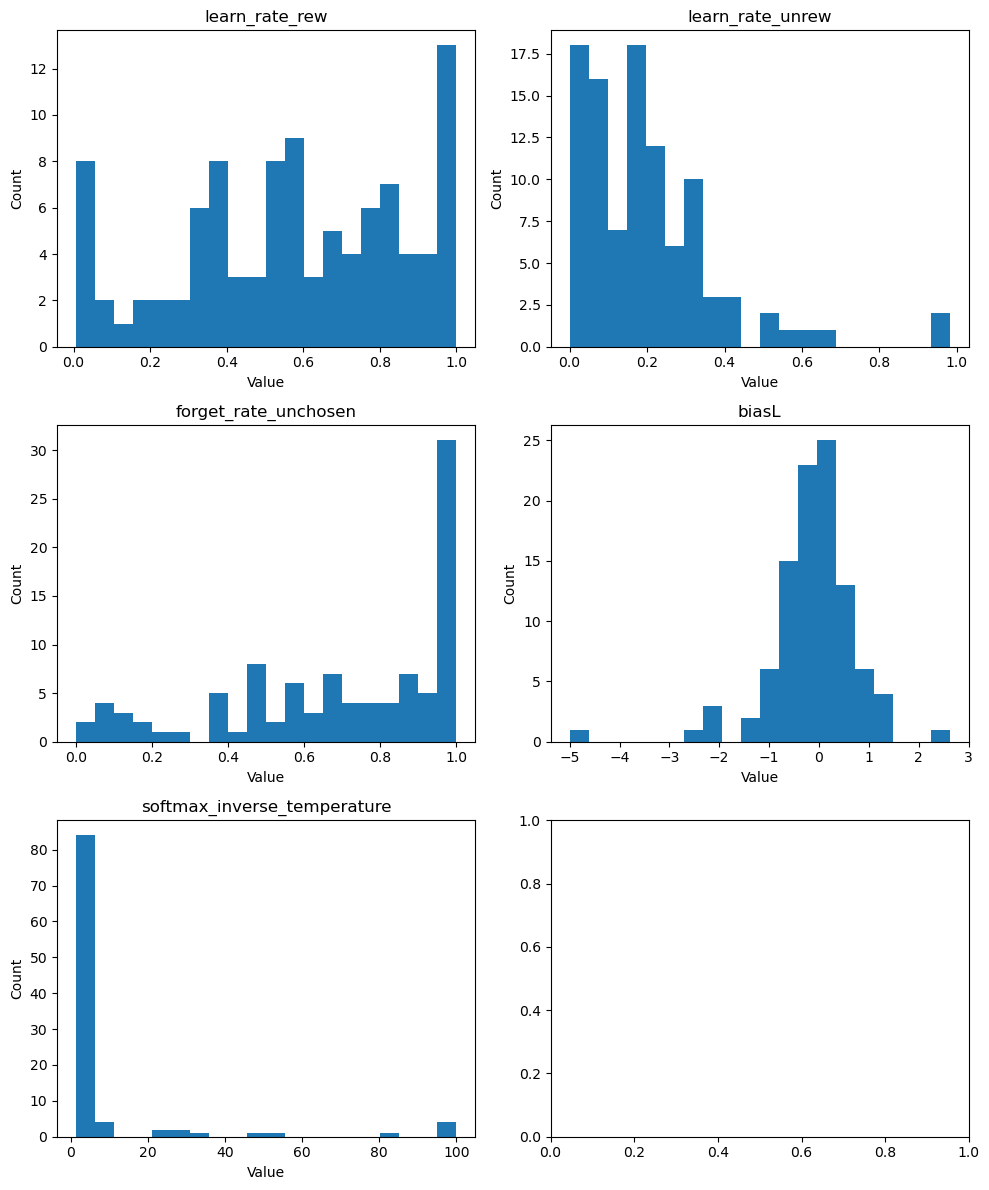

In [14]:
# Create subplots for histograms of each parameter
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.ravel()

# Plot histogram for each column
for idx, col in enumerate(df.columns):
    axes[idx].hist(df[col], bins=20)
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [39]:
merged_df = bu.merge_dataframes_subject_id(refrence_df, df)
merged_df

,subject_id,session_date,nwb_suffix_x,session_x,rig_x,user_name_x,curriculum_name_x,curriculum_version_x,current_stage_actual_x,task_x,...,NM_recorded_y,results_y,results_location_y,session_time_y,docDB_status_y,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
0,741211,2024-09-18,173004,20.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,[],behavior_741211_2024-09-18_17-30-04_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,17-30-04,2_uploaded and processed,0.306859,0.295367,0.713393,1.307859,5.735181
1,724172,2024-09-16,114638,25.0,323_EPHYS1,Ella Hilton,Uncoupled Without Baiting,2.2.1rwdDelay159,STAGE_FINAL,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.346859,0.173688,0.742682,0.007129,6.866458
2,733683,2024-09-12,92030,10.0,446-8-B,Ella Hilton,Uncoupled Without Baiting,2.2.1rwdDelay159,STAGE_3,Coupled Without Baiting,...,"['NE', 'NE']",behavior_733683_2024-09-12_09-20-30_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,09-20-30,2_uploaded and processed,0.728892,0.318346,0.949562,-0.178817,4.479776
3,744744,2024-09-11,91258,8.0,447-1-B,Huy Nguyen,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,[],behavior_744744_2024-09-11_09-12-58_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,09-12-58,2_uploaded and processed,0.826565,0.054588,0.498369,0.546750,2.119710
4,753124,2024-09-06,90233,7.0,446-7-C,margaret lee,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,[],behavior_753124_2024-09-06_09-02-33_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/8...,09-02-33,2_uploaded and processed,0.560053,0.028897,0.057833,0.152873,4.450795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,684891,2023-10-05,0,5.0,Red-3,Travis Ramirez,NaN,NaN,NaN,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.389234,0.031246,0.554898,-0.062239,3.194765
92,684890,2023-10-05,0,7.0,Red-2,Travis Ramirez,NaN,NaN,NaN,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.662058,0.312680,1.000000,-0.083287,4.164813
93,680599,2023-10-05,0,6.0,Red-1,Avalon Amaya,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.312631,0.223942,1.000000,-0.377754,4.035622
94,685642,2023-09-18,0,4.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.355054,0.005164,0.484957,-0.582579,4.686825


In [40]:
bu.analyze_column_distribution(merged_df, "curriculum_name_x")

{'value_counts': curriculum_name_x
 Uncoupled Without Baiting    33
 Uncoupled Baiting            11
 Coupled Baiting               7
 Name: count, dtype: int64,
 'percentages': curriculum_name_x
 Uncoupled Without Baiting    64.705882
 Uncoupled Baiting            21.568627
 Coupled Baiting              13.725490
 Name: proportion, dtype: float64,
 'total_count': 96,
 'unique_values': 3,
 'most_common': ('Uncoupled Without Baiting', 33),
 'least_common': ('Coupled Baiting', 7)}

In [43]:
merged_df.columns.to_list()

['subject_id',
 'session_date',
 'nwb_suffix_x',
 'session_x',
 'rig_x',
 'user_name_x',
 'curriculum_name_x',
 'curriculum_version_x',
 'current_stage_actual_x',
 'task_x',
 'notes_x',
 'experiment_description_x',
 'session_start_time_x',
 'session_end_time_x',
 'session_run_time_in_min_x',
 'water_in_session_foraging_x',
 'water_in_session_manual_x',
 'water_in_session_total_x',
 'water_after_session_x',
 'water_day_total_x',
 'base_weight_x',
 'target_weight_x',
 'target_weight_ratio_x',
 'weight_after_x',
 'laser_1_calibration_power_x',
 'laser_2_calibration_power_x',
 'laser_1_target_areas_x',
 'laser_2_target_areas_x',
 'commit_ID_x',
 'repo_url_x',
 'current_branch_x',
 'weight_after_ratio_x',
 'p_reward_sum_mean_x',
 'p_reward_sum_std_x',
 'p_reward_sum_median_x',
 'p_reward_contrast_mean_x',
 'p_reware_contrast_median_x',
 'effective_block_length_mean_x',
 'effective_block_length_std_x',
 'effective_block_length_median_x',
 'effective_block_length_min_x',
 'effective_block_len

In [44]:
curriculum = 'Uncoupled Without Baiting'

task_df = merged_df[merged_df['curriculum_name_x'] == curriculum]

task_df = task_df.loc[:, ['subject_id', 'session_date', 'learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'biasL', 'softmax_inverse_temperature', 'current_stage_actual_x']]

task_df.sort_values(by=['subject_id', 'session_date'], inplace=True)

task_df


,subject_id,session_date,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature,current_stage_actual_x
16,711039,2024-08-01,0.379397,0.407202,0.534698,0.045236,2.459537,STAGE_1_WARMUP
6,711039,2024-09-03,0.412963,0.193512,0.661219,0.311911,5.308833,STAGE_4
26,712634,2024-06-26,0.389709,0.069393,0.766750,-0.059145,3.257351,STAGE_4
51,713310,2024-04-25,1.000000,0.041308,0.386306,-0.749965,2.304118,STAGE_FINAL
35,713855,2024-06-05,0.602054,0.181367,1.000000,0.497617,3.214207,STAGE_2
23,714116,2024-07-03,0.579723,0.000000,1.000000,-0.583089,3.093909,STAGE_FINAL
8,714116,2024-08-19,0.801844,0.191465,0.974213,-0.018809,3.613972,GRADUATED
22,714728,2024-07-08,0.773322,0.274918,0.581514,-0.046589,2.052970,STAGE_2
14,715095,2024-08-05,0.476663,0.117105,0.990513,-0.420879,3.737097,STAGE_2
56,716325,2024-04-18,1.000000,0.176683,0.931962,-0.211197,3.200216,STAGE_FINAL
